In [2]:
import pandas as pd

import sys
print(sys.version)
sys.path.append('../../')
sys.path.append('../')
sys.path.append('../../../')


from drive.model_training.data_utils.extractors import * 
from drive.model_training.data_utils.animate_time_constant import * 
from first_order_model import *

from drive.util.model_func import *
from drive.util.transform_algebra import *



import matplotlib.animation as animation
from matplotlib.backend_bases import KeyEvent

import tqdm
import pickle

from matplotlib.backends.backend_pdf import PdfPages

import matplotlib as mpl
cmap = mpl.colormaps['viridis']



3.10.12 (main, Jul 19 2024, 11:05:56) [GCC 11.4.0]
3.10.12 (main, Jul 19 2024, 11:05:56) [GCC 11.4.0]


In [3]:
path_to_dataset = "/home/nicolassamson/ros2_ws/src/DRIVE/drive_datasets/data/warthog/wheels/ice/warthog_wheels_ice_ral2023/model_training_datasets/slip_dataset_all.pkl"


df = pd.read_pickle(path_to_dataset)

print_column_unique_column(df)


array(['body_vel_disturption_x', 'body_vel_disturption_y',
       'body_vel_disturption_yaw', 'calib_step', 'cmd_left', 'cmd_right',
       'gt_icp_pitch', 'gt_icp_roll', 'gt_icp_x', 'gt_icp_y',
       'gt_icp_yaw', 'gt_icp_z', 'icp_corrected_interpolated_x',
       'icp_corrected_interpolated_y', 'icp_interpolated_x',
       'icp_interpolated_y', 'icp_interpolated_yaw', 'icp_omega',
       'icp_pitch', 'icp_roll', 'icp_vel_x', 'icp_vel_y', 'icp_vel_yaw',
       'icp_vx', 'icp_vy', 'icp_x', 'icp_y', 'icp_yaw', 'icp_z',
       'idd_vel_x', 'idd_vel_y', 'idd_vel_yaw', 'imu_acceleration_x',
       'imu_acceleration_y', 'imu_acceleration_z', 'imu_yaw',
       'init_icp_pitch', 'init_icp_roll', 'init_icp_x', 'init_icp_y',
       'init_icp_yaw', 'init_icp_z', 'left_wheel_vel', 'right_wheel_vel',
       'steady_state_mask', 'transitory_state_mask',
       'transitory_vel_left', 'transitory_vel_right'], dtype=object)

In [4]:
def plot_projected_trajectory_vs_icp(list_x,list_y,list_yaw,list_names):

    fig, axs = plt.subplots(2,1)

    for x,y,yaw,name in zip(list_x,list_y,list_yaw,list_names):
        u, v  = [np.cos(yaw), np.sin(yaw)]

        color_id = np.arange(u.shape[0])
        axs[0].quiver(x,y,u,v,facecolor=cmap(color_id),label=name)
        time =[ i for i in range(yaw.shape[0])]

        print(time)
        scatter1 = axs[1].scatter(time,yaw)
        cbar = fig.colorbar(scatter1, ax=axs[0])
        cbar.set_label('Colorbar Label')
    axs[0].set_aspect('equal', adjustable='box')
    axs[0].set_ylabel("Y")
    axs[0].set_xlabel("X")
    axs[0].legend()
    axs[1].set_ylabel("yaw [rad]")
    axs[1].set_xlabel("iterations")
    

    
    

________icp_interpolated_x________
The column type: icp_interpolated_x
The resulting dataframe_shape: (591, 40)
Number of calibrating steps:591
Number of measurement by step: 40
Maximum 5.013996301721385
Minimum -6.749634994081889
__________________________________
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
(591, 40)


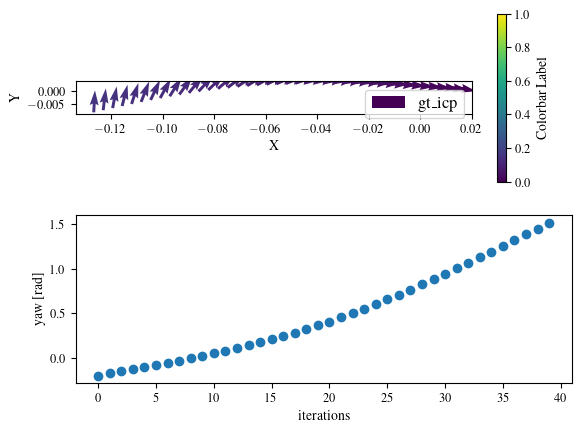

In [5]:
gt_icp_x = column_type_extractor(df,"icp_interpolated_x",verbose=True)
gt_icp_y = column_type_extractor(df,"icp_interpolated_y")
gt_icp_yaw = column_type_extractor(df,"icp_interpolated_yaw")




list_init = []
list_x = [gt_icp_x[0,:]]
list_y = [gt_icp_y[0,:]]
list_yaw = [gt_icp_yaw[0,:]]
list_names = ["gt_icp"]
plot_projected_trajectory_vs_icp(list_x,list_y,list_yaw,list_names)


print(gt_icp_x.shape)

________icp_interpolated_x________
The column type: icp_interpolated_x
The resulting dataframe_shape: (591, 40)
Number of calibrating steps:591
Number of measurement by step: 40
Maximum 5.013996301721385
Minimum -6.749634994081889
__________________________________
________cmd_right________
The column type: cmd_right
The resulting dataframe_shape: (591, 40)
Number of calibrating steps:591
Number of measurement by step: 40
Maximum 13.464639318354342
Minimum -13.932598240087291
_________________________
________idd_vel_x________
The column type: idd_vel_x
The resulting dataframe_shape: (591, 40)
Number of calibrating steps:591
Number of measurement by step: 40
Maximum 3.392265567407479
Minimum -3.608904560811275
_________________________
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,

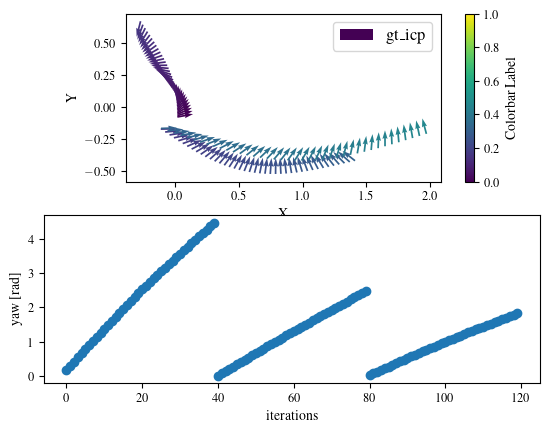

In [6]:
gt_icp_x = reshape_into_6sec_windows(column_type_extractor(df,"icp_interpolated_x",verbose=True))
gt_icp_y = reshape_into_6sec_windows(column_type_extractor(df,"icp_interpolated_y"))
gt_icp_yaw = reshape_into_6sec_windows(column_type_extractor(df,"icp_interpolated_yaw"))



size = gt_icp_x.shape[0]
#gt_icp_x[:,40:80] += gt_icp_x[:,39].reshape(size,1)
#gt_icp_x[:,80:120] += gt_icp_x[:,79].reshape(size,1)
#gt_icp_y[:,40:80] += gt_icp_y[:,39].reshape(size,1)
#gt_icp_y[:,80:120] += gt_icp_y[:,79].reshape(size,1)
#gt_icp_yaw[:,40:80] += gt_icp_yaw[:,39].reshape(size,1)
#gt_icp_yaw[:,80:120] += gt_icp_yaw[:,79].reshape(size,1)

cmd_left = column_type_extractor(df,"cmd_right",verbose=True)
cmd_right = column_type_extractor(df,"cmd_left")

#u = np.hstack((cmd_left,cmd_right))
#print(u.shape)
#compute_body_vel_IDD( u, robot='warthog-wheel')

idd_vel_x = column_type_extractor(df,"idd_vel_x",verbose=True)
idd_vel_y = column_type_extractor(df,"idd_vel_yaw")
idd_vel_yaw = column_type_extractor(df,"idd_vel_x_yaw")


id = 1
list_x = [gt_icp_x[id,:]]
list_y = [gt_icp_y[id,:]]
list_yaw = [gt_icp_yaw[id,:]]
list_names = ["gt_icp"]
plot_projected_trajectory_vs_icp(list_x,list_y,list_yaw,list_names)

print(gt_icp_x.shape)

________icp_interpolated_x________
The column type: icp_interpolated_x
The resulting dataframe_shape: (591, 40)
Number of calibrating steps:591
Number of measurement by step: 40
Maximum 5.013996301721385
Minimum -6.749634994081889
__________________________________
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119]
(197, 120)


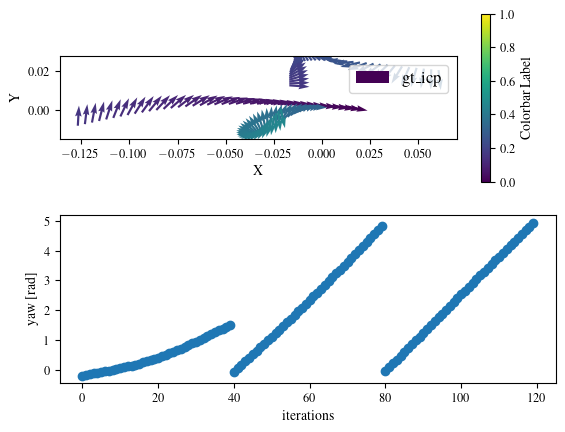

In [7]:
gt_icp_x = reshape_into_6sec_windows(column_type_extractor(df,"icp_interpolated_x",verbose=True))
gt_icp_y = reshape_into_6sec_windows(column_type_extractor(df,"icp_interpolated_y"))
gt_icp_yaw = reshape_into_6sec_windows(column_type_extractor(df,"icp_interpolated_yaw"))




list_x = [gt_icp_x[0,:]]
list_y = [gt_icp_y[0,:]]
list_yaw = [gt_icp_yaw[0,:]]
list_names = ["gt_icp"]
plot_projected_trajectory_vs_icp(list_x,list_y,list_yaw,list_names)

print(gt_icp_x.shape)




In [8]:
df_raw = pd.read_pickle("/home/nicolassamson/ros2_ws/src/DRIVE/drive_datasets/data/warthog/wheels/gravel/warthog_wheels_gravel_ral2023/model_training_datasets/warthog_gravel_dataframe.pkl")



['calib_step' 'cmd_left' 'cmd_right' 'end_time' 'gt_icp_pitch'
 'gt_icp_roll' 'gt_icp_x' 'gt_icp_y' 'gt_icp_yaw' 'gt_icp_z' 'icp_omega'
 'icp_pitch' 'icp_roll' 'icp_vx' 'icp_vy' 'icp_x' 'icp_y' 'icp_yaw'
 'icp_z' 'imu_acceleration_x' 'imu_acceleration_y' 'imu_acceleration_z'
 'imu_yaw' 'init_icp_pitch' 'init_icp_roll' 'init_icp_x' 'init_icp_y'
 'init_icp_yaw' 'init_icp_z' 'init_tf_pose_pitch' 'init_tf_pose_roll'
 'init_tf_pose_x' 'init_tf_pose_y' 'init_tf_pose_yaw' 'init_tf_pose_z'
 'left_wheel_vel' 'precedent_window_operation_point_mask'
 'right_wheel_vel' 'start_time' 'steady_state_mask' 'step_frame_icp_pitch'
 'step_frame_icp_roll' 'step_frame_icp_x' 'step_frame_icp_y'
 'step_frame_icp_yaw' 'step_frame_icp_z' 'transitory_state_mask']

 ____ Delta between 2 starts ___
count    359.000000
mean       3.665760
std        8.125387
min        1.949991
25%        2.000005
50%        2.000018
75%        2.050005
max       65.650085
Name: start_time, dtype: float64


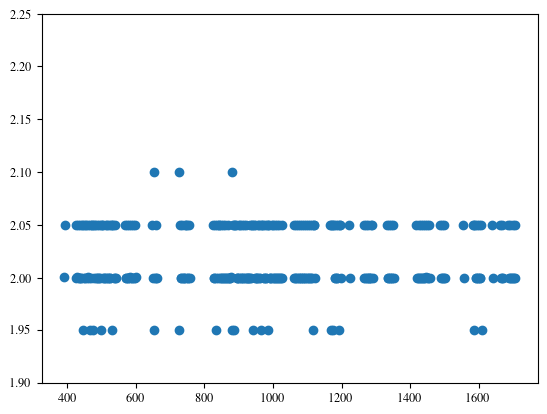

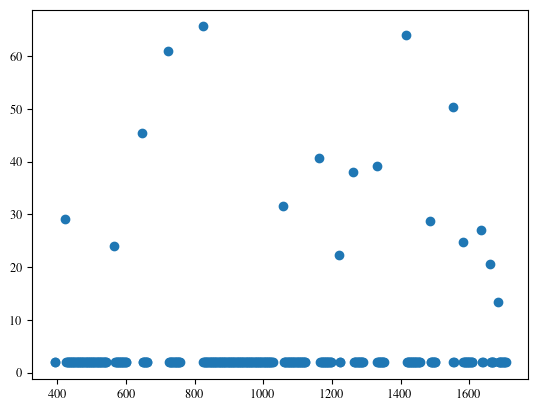

In [9]:
print(print_column_unique_column(df_raw))

time_of_windows = df_raw["end_time"] - df_raw["start_time"] 

time_between_start = df_raw["start_time"].diff()


print("\n ____ Delta between 2 starts ___")

print(time_between_start.describe())

plt.scatter(df_raw["start_time"], time_between_start)
plt.ylim(1.90,2.25)

fig, ax  = plt.subplots(1,1)
ax.scatter(df_raw["start_time"], time_between_start)


 ____ Duration of windows___
count    360.000000
mean       1.984177
std        0.034191
min        1.899988
25%        1.950015
50%        2.000004
75%        2.000014
max        2.050025
dtype: float64


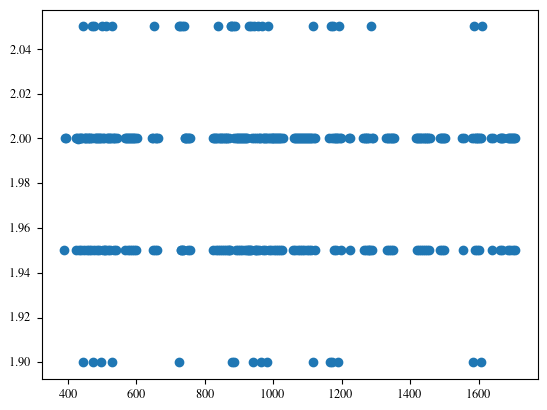

In [10]:
print("\n ____ Duration of windows___")
print(time_of_windows.describe())

fig2, ax2 = plt.subplots(1,1)
ax2.scatter(df_raw["start_time"], time_of_windows)

### Does the starting time is before the end of previous one 

In [11]:


shift = 1
delta_t_start_prev_end = pd.Series(df_raw["start_time"][shift:].to_numpy() - df_raw["end_time"][:-shift].to_numpy())


print(delta_t_start_prev_end.describe())
print(delta_t_start_prev_end.median())
print("Results of the 2% quantile",delta_t_start_prev_end.quantile(0.05))
print("Results of the 95% quantile",delta_t_start_prev_end.quantile(0.95))



count    359.000000
mean       1.681626
std        8.121711
min       -0.050011
25%        0.000000
50%        0.049993
75%        0.050004
max       63.650080
dtype: float64
0.04999256134033203
Results of the 2% quantile 0.0
Results of the 95% quantile 0.05003867149353027


# Compute only the time between windows of the same steps. 

Il n'y a donc pas de step de 2 seconde qui sont s/par/e par autre chose que 0.05 seconde une fois arondie. 

In [12]:
size = df_raw["start_time"].shape[0]
n_step = size//3
n_window = 3
start_column = df_raw["start_time"].to_numpy().reshape((int(size//n_window),int(n_window)))

end_column = df_raw["end_time"].to_numpy().reshape((int(size//n_window),int(n_window)))

differential = start_column[:,1:] - end_column[:,:2]
print("differential median",np.median(differential))
print("differential std",np.std(differential))

np.sum(np.round(differential,2) != 0.05)

differential median 0.04999804496765137
differential std 2.6697471821992906e-05


np.int64(0)

In [13]:
step_time = end_column[:,2] - start_column[:,0]
print("differential median",np.median(step_time))
print("differential std",np.std(step_time))

n_step
np.sum(np.round(step_time,2) != 6.05)/n_step *100 

differential median 6.050022125244141
differential std 0.010890625336052074


np.float64(5.0)

Seulement 5 % des steps ne durent pas de 6.05 secondes. Et ils sont 0.05 secondes de trops. ce qui ne devraient pas poser problemes. 


In [14]:
exception_step_time =step_time[np.round(step_time,2) != 6.05]
print(exception_step_time)


[6.09998751 6.10001445 6.099998   6.09998965 6.09998512 6.09997606]


# Revert the process of the tf 

In [15]:
print(print_column_unique_column(df_raw))
from scipy.spatial.transform import Rotation

['calib_step' 'cmd_left' 'cmd_right' 'end_time' 'gt_icp_pitch'
 'gt_icp_roll' 'gt_icp_x' 'gt_icp_y' 'gt_icp_yaw' 'gt_icp_z' 'icp_omega'
 'icp_pitch' 'icp_roll' 'icp_vx' 'icp_vy' 'icp_x' 'icp_y' 'icp_yaw'
 'icp_z' 'imu_acceleration_x' 'imu_acceleration_y' 'imu_acceleration_z'
 'imu_yaw' 'init_icp_pitch' 'init_icp_roll' 'init_icp_x' 'init_icp_y'
 'init_icp_yaw' 'init_icp_z' 'init_tf_pose_pitch' 'init_tf_pose_roll'
 'init_tf_pose_x' 'init_tf_pose_y' 'init_tf_pose_yaw' 'init_tf_pose_z'
 'left_wheel_vel' 'precedent_window_operation_point_mask'
 'right_wheel_vel' 'start_time' 'steady_state_mask' 'step_frame_icp_pitch'
 'step_frame_icp_roll' 'step_frame_icp_x' 'step_frame_icp_y'
 'step_frame_icp_yaw' 'step_frame_icp_z' 'transitory_state_mask']


In [16]:

def compute_all_tf(tf_poses,tf_euler):
    list_tf = []

    size = tf_poses.shape[0]

    for i in range(size):
        transform = np.eye(4)
        rotation = Rotation.from_euler("xyz",tf_euler[i,:])
        
        transform[:3,:3] = rotation.as_matrix()
        transform[:3,3] = tf_poses[i,:]

        list_tf.append(transform)
    
    return list_tf


def put_all_icp_in_stepref(df,n_window = 3):

    tf_pose  = df[["init_tf_pose_x","init_tf_pose_y","init_tf_pose_z"]].to_numpy()
    tf_euler = df[["init_tf_pose_roll","init_tf_pose_pitch","init_tf_pose_yaw"]].to_numpy()
    list_tf = compute_all_tf(tf_pose,tf_euler)

    icp_x = column_type_extractor(df,"icp_x",verbose=True)
    icp_y = column_type_extractor(df,"icp_y")
    icp_z = column_type_extractor(df,"icp_z")
    
    icp_roll = column_type_extractor(df,"icp_roll")
    icp_pitch = column_type_extractor(df,"icp_pitch")
    icp_yaw = column_type_extractor(df,"icp_yaw")

    size = tf_pose.shape[0]

    step_exp_x = np.zeros_like(icp_x)
    step_exp_y = np.zeros_like(icp_x)
    step_exp_z = np.zeros_like(icp_x)
    step_exp_roll = np.zeros_like(icp_x)
    step_exp_pitch = np.zeros_like(icp_x)
    step_exp_yaw = np.zeros_like(icp_x)

    tf_to_reapplied = np.eye(4)

    for i in  range(size):

        window_poses = np.vstack((icp_x[i,:],icp_y[i,:],icp_z[i,:]))
        window_angles = np.vstack((icp_roll[i,:],icp_pitch[i,:],icp_yaw[i,:]))

        tf_map_first_point = list_tf[i]

        step_window_poses = np.zeros_like(window_poses)

        step_window_euler_angles = np.zeros_like(window_poses)
        
        if i % n_window ==0: 
            tf_to_reapplied = np.linalg.inv(tf_map_first_point)

        for j in range(window_poses.shape[1]):

            pose = np.eye(4)
            rotation = Rotation.from_euler("xyz",window_angles[:,j])
            pose[:3,:3] = rotation.as_matrix()
            pose[:3,3] = window_poses[:,j]

            pose_map = tf_to_reapplied @ tf_map_first_point @ pose
            
            step_window_poses[:,j] = pose_map[:3,3]
            step_window_euler_angles[:,j] = Rotation.from_matrix(pose_map[0:3,0:3]).as_euler("xyz")

        
        step_exp_x[i,:] = step_window_poses[0,:]
        step_exp_y[i,:] = step_window_poses[1,:]
        step_exp_z[i,:] = step_window_poses[2,:]
        step_exp_roll[i,:] = step_window_euler_angles[0,:]
        step_exp_pitch[i,:] = step_window_euler_angles[1,:]
        step_exp_yaw[i,:] = step_window_euler_angles[2,:]



        
    return step_exp_x, step_exp_y, step_exp_z, step_exp_roll,step_exp_pitch, step_exp_yaw


map_x, map_y, map_z, map_roll, map_pitch, map_yaw = put_all_icp_in_stepref(df_raw)


________icp_x________
The column type: icp_x
The resulting dataframe_shape: (360, 40)
Number of calibrating steps:360
Number of measurement by step: 40
Maximum 7.776093631347164
Minimum -7.791518228201689
_____________________


In [17]:
map_x_step = reshape_into_6sec_windows(map_x)
map_y_step = reshape_into_6sec_windows(map_y)
map_yaw_step = reshape_into_6sec_windows(map_yaw)

print(map_x_step.shape)

(120, 120)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119]


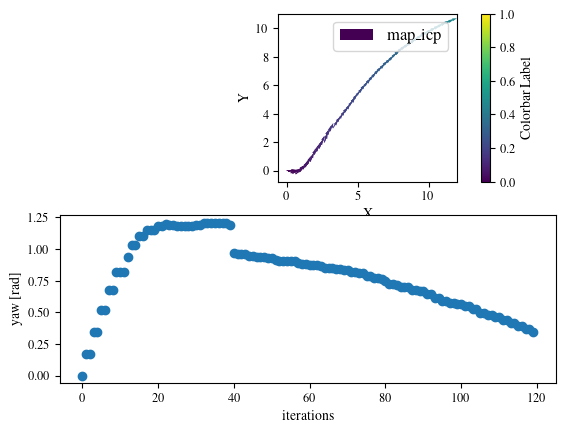

In [18]:
id =20
list_x = [map_x_step[id,:]]
list_y = [map_y_step[id,:]]
list_yaw = [map_yaw_step[id,:]]
list_names = ["map_icp"]
plot_projected_trajectory_vs_icp(list_x,list_y,list_yaw,list_names)

# Create time mask 

In [19]:
def create_last_window_mask(df,n_window=3,time_per_window=2):
    """The goal is to compute mask indicating if the precedent window can be used for the operation point. 

    1 == True  (precedent_window ==precedent_time)
    0 == False  (precedent_window !=precedent_time)
    
    Args:
        mask_with_0 (_type_): Mask indicating wether the precedent window can be used to extract the point. 
    """
    size = df_raw["start_time"].shape[0]
    n_step = size//3

    start_column = df["start_time"].to_numpy()#.reshape((int(size//n_window),int(n_window)))
    end_column = df["end_time"].to_numpy()#.reshape((int(size//n_window),int(n_window)))

    differential = start_column[1:] - end_column[:-1]

    mask = list(differential < time_per_window*1.10)
    mask_with_0 = np.array([False] + mask)
    mask_reshape = mask_with_0.reshape((int(size//n_window),int(n_window)))

    return mask_with_0

mask_ = create_last_window_mask(df_raw,n_window=3,time_per_window=2)

# Validation of the mask 

Normally if I applied the mask on the array (differential = start_column[1:] - end_column[:-1]) I should get only the timmestamp where there is a huge gap. 

(0.0, 68.0)

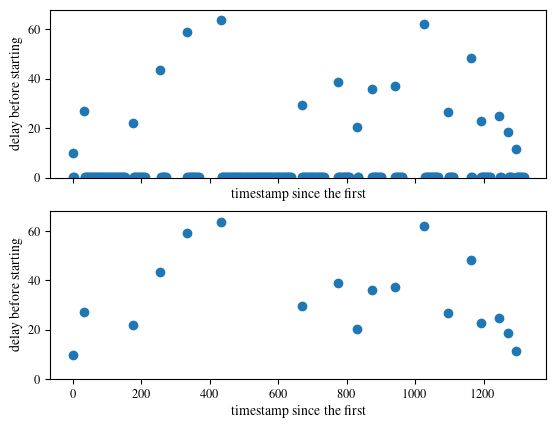

In [20]:
fig,axs = plt.subplots(2,1,sharex=True)

size = df_raw["start_time"].shape[0]
n_step = size//3
start_column = df_raw["start_time"].to_numpy()#.reshape((int(size//n_window),int(n_window)))
end_column = df_raw["end_time"].to_numpy()#.reshape((int(size//n_window),int(n_window)))
 
differential = np.array([10] + list(start_column[1:] - end_column[:-1])) # Supposing that the first window starts at 0
axs[1].scatter(start_column[mask_==False]-start_column[0], differential[mask_==False])
axs[1].set_ylabel("delay before starting")
axs[1].set_xlabel("timestamp since the first")
axs[1].set_ylim(0,68)
axs[0].scatter(start_column-start_column[0], differential)
axs[0].set_ylabel("delay before starting")
axs[0].set_xlabel("timestamp since the first")
axs[0].set_ylim(0,68)


The mask extract well the problematic timestamp. 

# Validation

In [28]:
print_column_unique_column(df_raw)

steps_frame_icp_x = reshape_into_6sec_windows(column_type_extractor(df_raw,"step_frame_icp_x"))
steps_frame_icp_y = reshape_into_6sec_windows(column_type_extractor(df_raw,"step_frame_icp_y"))
steps_frame_icp_yaw = reshape_into_6sec_windows(column_type_extractor(df_raw,"step_frame_icp_yaw"))




[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119]


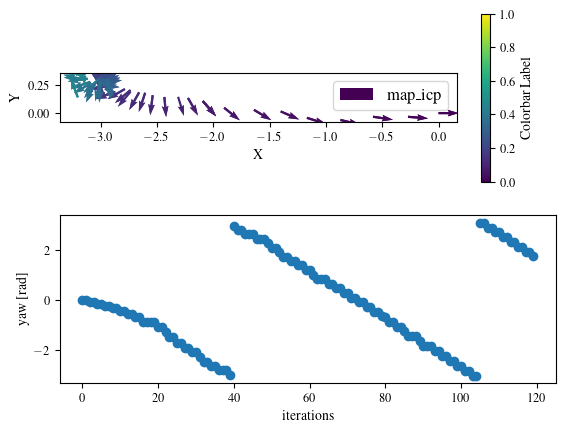

In [32]:
id = 80
list_x = [steps_frame_icp_x[id,:]]
list_y = [steps_frame_icp_y[id,:]]
list_yaw = [steps_frame_icp_yaw[id,:]]
list_names = ["map_icp"]
plot_projected_trajectory_vs_icp(list_x,list_y,list_yaw,list_names)

# Data columns

In [33]:
path = "/home/nicolassamson/ros2_ws/src/DRIVE/drive_datasets/data/warthog/wheels/gravel/warthog_wheels_gravel_ral2023/model_training_datasets/steady_state_results.pkl"

df_slip_raw = pd.read_pickle(path)

In [34]:
print_column_unique_column(df_slip_raw)

array(['cmd_body_x', 'cmd_body_yaw', 'cmd_left_wheels',
       'cmd_right_wheels', 'icp_vel_x_smoothed', 'icp_vel_yaw_smoothed',
       'left_wheel_vel_gains', 'left_wheel_vel_operation_points',
       'left_wheel_vel_predictions', 'left_wheel_vel_predictions_',
       'left_wheel_vel_steps', 'left_wheel_vel_time_constants',
       'left_wheel_vel_time_delay',
       'left_wheel_vel_time_delay_problematic_computation',
       'odom_speed_left_wheels', 'odom_speed_right_wheels',
       'right_wheel_vel_gains', 'right_wheel_vel_operation_points',
       'right_wheel_vel_predictions', 'right_wheel_vel_predictions_',
       'right_wheel_vel_steps', 'right_wheel_vel_time_constants',
       'right_wheel_vel_time_delay',
       'right_wheel_vel_time_delay_problematic_computation', 'robot',
       'slip_body_x_ss', 'slip_body_y_ss', 'slip_body_yaw_ss',
       'slip_wheel_left_ss', 'slip_wheel_right_ss', 'step_frame_vx_gains',
       'step_frame_vx_operation_points', 'step_frame_vx_predictions'